In [1]:
import os
import copy

In [2]:
from matplotlib import pyplot as plt
import cv2
import numpy as np

In [3]:
import torch

In [4]:
from yolox.exp import get_exp
from yolox.data.datasets import COCO_CLASSES
from yolox.utils import vis, postprocess
from tools.demo import Predictor

In [5]:
exp_file = "exps/default/yolox_x.py"
name = None

device = 'gpu'
fp16 = False
legacy = False

In [6]:
exp = get_exp(exp_file, name)
print(exp.test_size)

(640, 640)


In [7]:
file_name = os.path.join(exp.output_dir, exp.exp_name)

In [8]:
model = exp.get_model()
model.eval()

YOLOX(
  (backbone): YOLOPAFPN(
    (backbone): CSPDarknet(
      (stem): Focus(
        (conv): BaseConv(
          (conv): Conv2d(12, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (dark2): Sequential(
        (0): BaseConv(
          (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): CSPLayer(
          (conv1): BaseConv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (conv2): BaseConv(
            (conv): Conv2d(160, 80, kernel

In [9]:
ckpt_file = "./weights/yolox_x.pth"
ckpt = torch.load(ckpt_file, map_location="cpu")
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [10]:
model.cuda()

YOLOX(
  (backbone): YOLOPAFPN(
    (backbone): CSPDarknet(
      (stem): Focus(
        (conv): BaseConv(
          (conv): Conv2d(12, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (dark2): Sequential(
        (0): BaseConv(
          (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): CSPLayer(
          (conv1): BaseConv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (conv2): BaseConv(
            (conv): Conv2d(160, 80, kernel

In [11]:
trt_file = None
decoder = None

In [12]:
predictor = Predictor(
        model, exp, COCO_CLASSES, trt_file, decoder,
        device, fp16, legacy,
    )

In [13]:
def image_demo(predictor, image_name):
    outputs, img_info = predictor.inference(image_name)
    result_image = predictor.visual(outputs[0], img_info, predictor.confthre)
    
    print(result_image.shape)
    # BGR2RGB
    result_image = result_image[:,:,::-1]
    
    plt.imshow(result_image)


2022-09-23 18:08:03.721 | INFO     | tools.demo:inference:165 - Infer time: 2.7338s


(576, 768, 3)


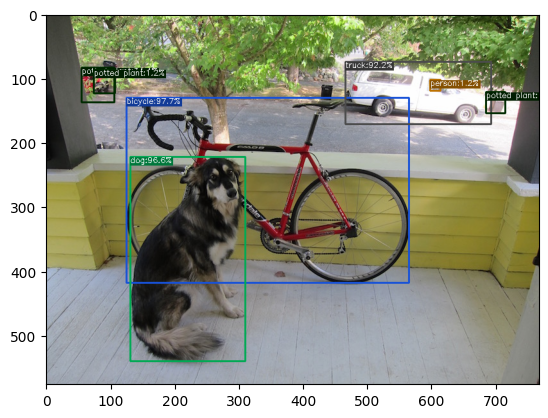

In [14]:
image_name = './assets/dog.jpg'
image_demo(predictor, image_name)

In [15]:
def split_image_demo(predictor, image_name, model, cls_conf=0.35):
    img = cv2.imread(image_name)
    print(img.shape)
    width = img.shape[1]
    height = img.shape[0]
    plt.imshow(img[:,:,::-1])
    img_raw = copy.deepcopy(img)
    
    fig, axs = plt.subplots(2, 2)
    
    img_sub_11 = img[:int(height/2),:int(width/2),::]
    img_sub_12 = img[:int(height/2),int(width/2):,::]
    img_sub_21 = img[int(height/2):,:int(width/2),::]
    img_sub_22 = img[int(height/2):,int(width/2):,::]
    
    print("sub_11: " + str(img_sub_11.shape))
    print("sub_12: " + str(img_sub_12.shape))
    print("sub_21: " + str(img_sub_21.shape))
    print("sub_22: " + str(img_sub_22.shape))
    
    axs[0][0].imshow(img_sub_11[:,:,::-1])
    axs[0][1].imshow(img_sub_12[:,:,::-1])
    axs[1][0].imshow(img_sub_21[:,:,::-1])
    axs[1][1].imshow(img_sub_22[:,:,::-1])
    
    img_info_sub_11 = {"id": 0}
    img_info_sub_11["height"] = img_sub_11.shape[0]
    img_info_sub_11["width"] = img_sub_11.shape[1]
    img_info_sub_11["raw_img"] = img_sub_11
    ratio = min(320 / img_sub_11.shape[0], 320 / img_sub_11.shape[1])
    img_info_sub_11["ratio"] = ratio
    
    img_info_sub_12 = {"id": 0}
    img_info_sub_12["height"] = img_sub_12.shape[0]
    img_info_sub_12["width"] = img_sub_12.shape[1]
    img_info_sub_12["raw_img"] = img_sub_12
    ratio = min(320 / img_sub_12.shape[0], 320 / img_sub_12.shape[1])
    img_info_sub_12["ratio"] = ratio
    
    img_info_sub_21 = {"id": 0}
    img_info_sub_21["height"] = img_sub_21.shape[0]
    img_info_sub_21["width"] = img_sub_21.shape[1]
    img_info_sub_21["raw_img"] = img_sub_21
    ratio = min(320 / img_sub_21.shape[0], 320 / img_sub_21.shape[1])
    img_info_sub_21["ratio"] = ratio
    
    img_info_sub_22 = {"id": 0}
    img_info_sub_22["height"] = img_sub_22.shape[0]
    img_info_sub_22["width"] = img_sub_22.shape[1]
    img_info_sub_22["raw_img"] = img_sub_22
    ratio = min(320 / img_sub_22.shape[0], 320 / img_sub_22.shape[1])
    img_info_sub_22["ratio"] = ratio
    
    img_sub_11, _ = predictor.preproc(img_sub_11, None, (320, 320))
    img_sub_12, _ = predictor.preproc(img_sub_12, None, (320, 320))
    img_sub_21, _ = predictor.preproc(img_sub_21, None, (320, 320))
    img_sub_22, _ = predictor.preproc(img_sub_22, None, (320, 320))
    
    img_sub_11 = torch.from_numpy(img_sub_11).unsqueeze(0).float().cuda()
    outputs_sub_11 = model(img_sub_11)
    
    outputs_sub_11 = outputs_sub_11.cpu()
    outputs_sub_11 = postprocess(
                outputs_sub_11, predictor.num_classes, predictor.confthre,
                predictor.nmsthre, class_agnostic=True
            )[0]
    bboxes_sub_11 = outputs_sub_11[:, 0:4]
    bboxes_sub_11 /= img_info_sub_11["ratio"]
    cls_sub_11 = outputs_sub_11[:, 6]
    scores_sub_11 = outputs_sub_11[:, 4] * outputs_sub_11[:, 5]
    
    img_sub_12 = torch.from_numpy(img_sub_12).unsqueeze(0).float().cuda()
    outputs_sub_12 = model(img_sub_12)
    
    outputs_sub_12 = outputs_sub_12.cpu()
    outputs_sub_12 = postprocess(
                outputs_sub_12, predictor.num_classes, predictor.confthre,
                predictor.nmsthre, class_agnostic=True
            )[0]
    bboxes_sub_12 = outputs_sub_12[:, 0:4]
    bboxes_sub_12 /= img_info_sub_12["ratio"]
    cls_sub_12 = outputs_sub_12[:, 6]
    scores_sub_12 = outputs_sub_12[:, 4] * outputs_sub_12[:, 5]
    
    img_sub_21 = torch.from_numpy(img_sub_21).unsqueeze(0).float().cuda()
    outputs_sub_21 = model(img_sub_21)
    
    outputs_sub_21 = outputs_sub_21.cpu()
    outputs_sub_21 = postprocess(
                outputs_sub_21, predictor.num_classes, predictor.confthre,
                predictor.nmsthre, class_agnostic=True
            )[0]
    bboxes_sub_21 = outputs_sub_21[:, 0:4]
    bboxes_sub_21 /= img_info_sub_21["ratio"]
    cls_sub_21 = outputs_sub_21[:, 6]
    scores_sub_21 = outputs_sub_21[:, 4] * outputs_sub_21[:, 5]
    
    img_sub_22 = torch.from_numpy(img_sub_22).unsqueeze(0).float().cuda()
    outputs_sub_22 = model(img_sub_22)
    
    outputs_sub_22 = outputs_sub_22.cpu()
    outputs_sub_22 = postprocess(
                outputs_sub_22, predictor.num_classes, predictor.confthre,
                predictor.nmsthre, class_agnostic=True
            )[0]
    bboxes_sub_22 = outputs_sub_22[:, 0:4]
    bboxes_sub_22 /= img_info_sub_22["ratio"]
    cls_sub_22 = outputs_sub_22[:, 6]
    scores_sub_22 = outputs_sub_22[:, 4] * outputs_sub_22[:, 5]
    
    vis_res_sub_11 = vis(img_info_sub_11["raw_img"], bboxes_sub_11, scores_sub_11, cls_sub_11, cls_conf, predictor.cls_names)
    vis_res_sub_12 = vis(img_info_sub_12["raw_img"], bboxes_sub_12, scores_sub_12, cls_sub_12, cls_conf, predictor.cls_names)
    vis_res_sub_21 = vis(img_info_sub_21["raw_img"], bboxes_sub_21, scores_sub_21, cls_sub_21, cls_conf, predictor.cls_names)
    vis_res_sub_22 = vis(img_info_sub_22["raw_img"], bboxes_sub_22, scores_sub_22, cls_sub_22, cls_conf, predictor.cls_names)
    
    fig_res, axs_res = plt.subplots(2, 2)
    axs_res[0][0].imshow(vis_res_sub_11[:,:,::-1])
    axs_res[0][1].imshow(vis_res_sub_12[:,:,::-1])
    axs_res[1][0].imshow(vis_res_sub_21[:,:,::-1])
    axs_res[1][1].imshow(vis_res_sub_22[:,:,::-1])
    
    print(img_info_sub_12["ratio"])
#     width_offset = 320 / img_info_sub_12["ratio"]
#     height_offset = 320 / img_info_sub_12["ratio"]
    width_offset = img_info_sub_12["width"]
    height_offset = img_info_sub_12["height"]
    
    plt.figure()
    vis_res_full = vis(img_raw, bboxes_sub_11, scores_sub_11, cls_sub_11, cls_conf, predictor.cls_names)
    plt.imshow(vis_res_full[:,:,::-1])
    
    plt.figure()
    bboxes_sub_12[:, 0] += width_offset
    bboxes_sub_12[:, 2] += width_offset
    vis_res_full = vis(img_raw, bboxes_sub_12, scores_sub_12, cls_sub_12, cls_conf, predictor.cls_names)
    plt.imshow(vis_res_full[:,:,::-1])
    
    plt.figure()
    bboxes_sub_21[:, 1] += height_offset
    bboxes_sub_21[:, 3] += height_offset
    vis_res_full = vis(img_raw, bboxes_sub_21, scores_sub_21, cls_sub_21, cls_conf, predictor.cls_names)
    plt.imshow(vis_res_full[:,:,::-1])
    
    plt.figure()
    bboxes_sub_22[:, 0] += width_offset
    bboxes_sub_22[:, 2] += width_offset
    bboxes_sub_22[:, 1] += height_offset
    bboxes_sub_22[:, 3] += height_offset
    vis_res_full = vis(img_raw, bboxes_sub_22, scores_sub_22, cls_sub_22, cls_conf, predictor.cls_names)
    plt.imshow(vis_res_full[:,:,::-1])

In [16]:
img = cv2.imread(image_name)
img, _ = predictor.preproc(img, None, (320,320))
print(img.shape)

(3, 320, 320)


In [17]:
img = torch.from_numpy(img).unsqueeze(0).float().cuda()
outputs = model(img)

In [18]:
outputs

tensor([[[-2.2574e-01,  5.5751e+00,  2.1389e+01,  ...,  9.6746e-03,
           6.7775e-03,  5.1691e-03],
         [ 8.8985e+00,  6.0115e+00,  2.0103e+01,  ...,  1.3022e-02,
           8.0108e-03,  6.9288e-03],
         [ 2.7987e+01,  6.6695e+00,  2.3852e+01,  ...,  8.9913e-03,
           3.8580e-03,  3.9060e-03],
         ...,
         [ 2.3115e+02,  2.6096e+02,  3.4119e+02,  ...,  5.0290e-03,
           4.9943e-03,  5.4755e-03],
         [ 2.4479e+02,  2.6609e+02,  3.0729e+02,  ...,  9.8620e-03,
           5.3933e-03,  5.6746e-03],
         [ 2.7833e+02,  2.8697e+02,  5.1426e+01,  ...,  7.8237e-03,
           5.2523e-03,  7.9800e-03]]], device='cuda:0',
       grad_fn=<AsStridedBackward0>)

(576, 768, 3)
sub_11: (288, 384, 3)
sub_12: (288, 384, 3)
sub_21: (288, 384, 3)
sub_22: (288, 384, 3)
0.8333333333333334


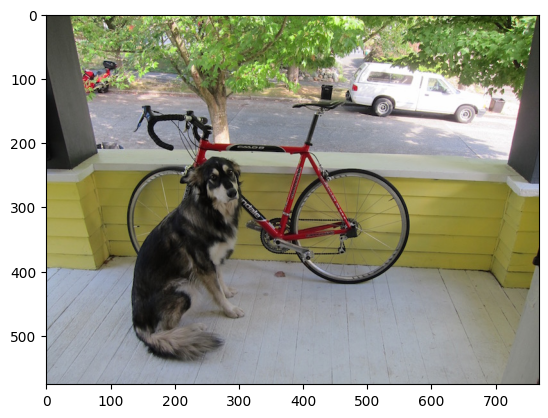

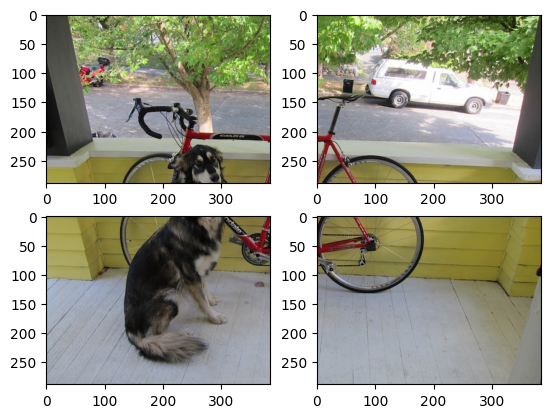

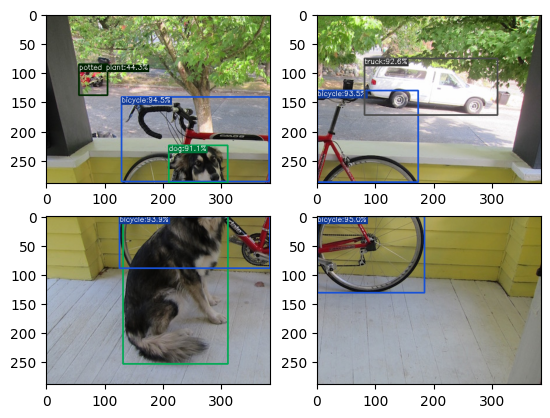

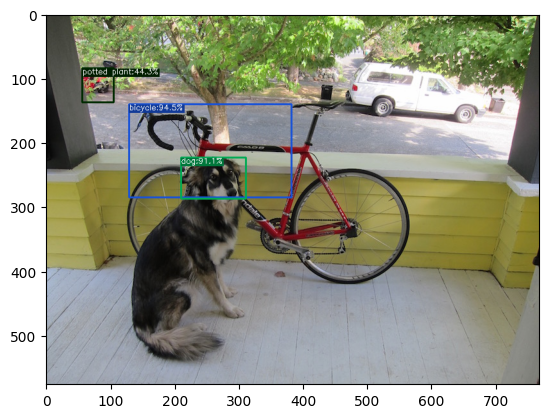

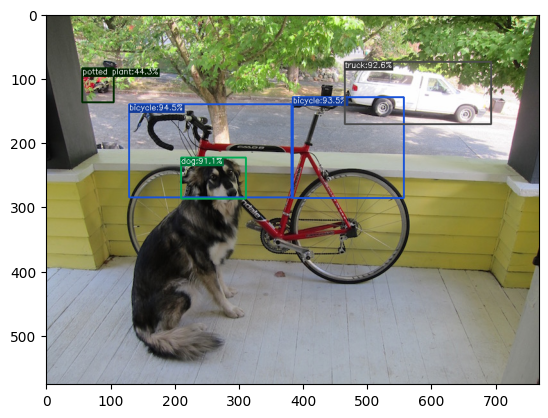

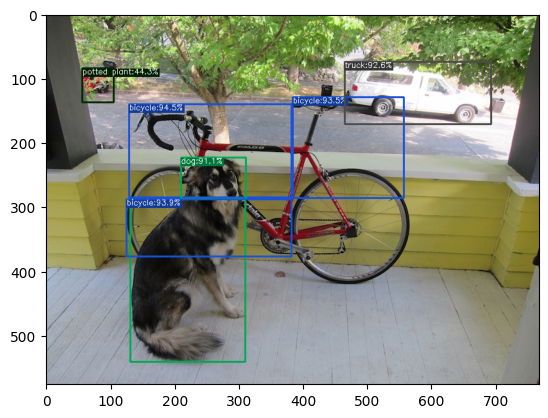

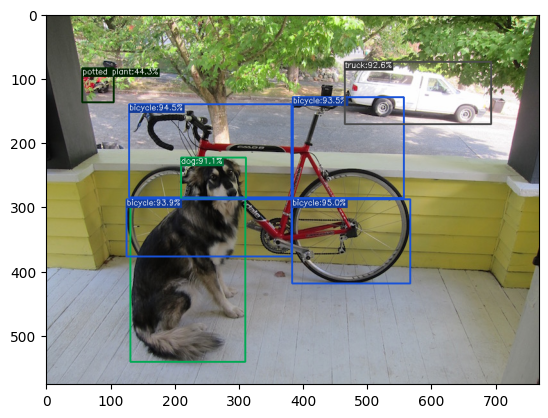

In [19]:
split_image_demo(predictor, image_name, model)

In [22]:
def split_image_demo_pre(predictor, image_name, model, cls_conf=0.35):
    img = cv2.imread(image_name)
#     width = img.shape[1]
#     height = img.shape[0]
    plt.imshow(img[:,:,::-1])
    
    fig = plt.figure()
    img, _ = predictor.preproc(img, None, exp.test_size)
    show_img = np.transpose(img/255.0, (1,2,0))
    plt.imshow(show_img[:,:,::-1])
    
    width = img.shape[2]
    height = img.shape[1]
    img_raw = copy.deepcopy(img)

    fig, axs = plt.subplots(2, 2)
    
    img_sub_11 = img[::, :int(height/2),:int(width/2)]
    img_sub_12 = img[::, :int(height/2),int(width/2):]
    img_sub_21 = img[::, int(height/2):,:int(width/2)]
    img_sub_22 = img[::, int(height/2):,int(width/2):]
    
    print("sub_11: " + str(img_sub_11.shape))
    print("sub_12: " + str(img_sub_12.shape))
    print("sub_21: " + str(img_sub_21.shape))
    print("sub_22: " + str(img_sub_22.shape))
    
    axs[0][0].imshow(np.transpose(img_sub_11/255.0,(1,2,0))[:,:,::-1])
    axs[0][1].imshow(np.transpose(img_sub_12/255.0,(1,2,0))[:,:,::-1])
    axs[1][0].imshow(np.transpose(img_sub_21/255.0,(1,2,0))[:,:,::-1])
    axs[1][1].imshow(np.transpose(img_sub_22/255.0,(1,2,0))[:,:,::-1])
    
    img_info_sub_11 = {"id": 0}
    img_info_sub_11["height"] = img_sub_11.shape[0]
    img_info_sub_11["width"] = img_sub_11.shape[1]
    img_info_sub_11["raw_img"] = img_sub_11
#     ratio = min(320 / img_sub_11.shape[0], 320 / img_sub_11.shape[1])
#     img_info_sub_11["ratio"] = ratio
    
    img_info_sub_12 = {"id": 0}
    img_info_sub_12["height"] = img_sub_12.shape[0]
    img_info_sub_12["width"] = img_sub_12.shape[1]
    img_info_sub_12["raw_img"] = img_sub_12
#     ratio = min(320 / img_sub_12.shape[0], 320 / img_sub_12.shape[1])
#     img_info_sub_12["ratio"] = ratio
    
    img_info_sub_21 = {"id": 0}
    img_info_sub_21["height"] = img_sub_21.shape[0]
    img_info_sub_21["width"] = img_sub_21.shape[1]
    img_info_sub_21["raw_img"] = img_sub_21
#     ratio = min(320 / img_sub_21.shape[0], 320 / img_sub_21.shape[1])
#     img_info_sub_21["ratio"] = ratio
    
    img_info_sub_22 = {"id": 0}
    img_info_sub_22["height"] = img_sub_22.shape[0]
    img_info_sub_22["width"] = img_sub_22.shape[1]
    img_info_sub_22["raw_img"] = img_sub_22
#     ratio = min(320 / img_sub_22.shape[0], 320 / img_sub_22.shape[1])
#     img_info_sub_22["ratio"] = ratio
    
#     img_sub_11, _ = predictor.preproc(img_sub_11, None, (320, 320))
#     img_sub_12, _ = predictor.preproc(img_sub_12, None, (320, 320))
#     img_sub_21, _ = predictor.preproc(img_sub_21, None, (320, 320))
#     img_sub_22, _ = predictor.preproc(img_sub_22, None, (320, 320))
    
    print(img_sub_11.shape)
    img_sub_11 = torch.from_numpy(img_sub_11).unsqueeze(0).float().cuda()
    outputs_sub_11 = model(img_sub_11)
    
    outputs_sub_11 = outputs_sub_11.cpu()
    outputs_sub_11 = postprocess(
                outputs_sub_11, predictor.num_classes, predictor.confthre,
                predictor.nmsthre, class_agnostic=True
            )[0]
    bboxes_sub_11 = outputs_sub_11[:, 0:4]
#     bboxes_sub_11 /= img_info_sub_11["ratio"]
    cls_sub_11 = outputs_sub_11[:, 6]
    scores_sub_11 = outputs_sub_11[:, 4] * outputs_sub_11[:, 5]
    
    img_sub_12 = torch.from_numpy(img_sub_12).unsqueeze(0).float().cuda()
    outputs_sub_12 = model(img_sub_12)
    
    outputs_sub_12 = outputs_sub_12.cpu()
    outputs_sub_12 = postprocess(
                outputs_sub_12, predictor.num_classes, predictor.confthre,
                predictor.nmsthre, class_agnostic=True
            )[0]
    bboxes_sub_12 = outputs_sub_12[:, 0:4]
#     bboxes_sub_12 /= img_info_sub_12["ratio"]
    cls_sub_12 = outputs_sub_12[:, 6]
    scores_sub_12 = outputs_sub_12[:, 4] * outputs_sub_12[:, 5]
    
    img_sub_21 = torch.from_numpy(img_sub_21).unsqueeze(0).float().cuda()
    outputs_sub_21 = model(img_sub_21)
    
    outputs_sub_21 = outputs_sub_21.cpu()
    outputs_sub_21 = postprocess(
                outputs_sub_21, predictor.num_classes, predictor.confthre,
                predictor.nmsthre, class_agnostic=True
            )[0]
    bboxes_sub_21 = outputs_sub_21[:, 0:4]
#     bboxes_sub_21 /= img_info_sub_21["ratio"]
    cls_sub_21 = outputs_sub_21[:, 6]
    scores_sub_21 = outputs_sub_21[:, 4] * outputs_sub_21[:, 5]
    
    img_sub_22 = torch.from_numpy(img_sub_22).unsqueeze(0).float().cuda()
    outputs_sub_22 = model(img_sub_22)
    
    outputs_sub_22 = outputs_sub_22.cpu()
    outputs_sub_22 = postprocess(
                outputs_sub_22, predictor.num_classes, predictor.confthre,
                predictor.nmsthre, class_agnostic=True
            )[0]
    bboxes_sub_22 = outputs_sub_22[:, 0:4]
#     bboxes_sub_22 /= img_info_sub_22["ratio"]
    cls_sub_22 = outputs_sub_22[:, 6]
    scores_sub_22 = outputs_sub_22[:, 4] * outputs_sub_22[:, 5]
    
    print(img_info_sub_11["raw_img"].shape)
    vis_res_sub_11 = vis(cv2.cvtColor(np.transpose(img_info_sub_11["raw_img"],(1,2,0)), cv2.COLOR_RGB2BGR), bboxes_sub_11, scores_sub_11, cls_sub_11, cls_conf, predictor.cls_names)
    vis_res_sub_12 = vis(cv2.cvtColor(np.transpose(img_info_sub_12["raw_img"],(1,2,0)), cv2.COLOR_RGB2BGR), bboxes_sub_12, scores_sub_12, cls_sub_12, cls_conf, predictor.cls_names)
    vis_res_sub_21 = vis(cv2.cvtColor(np.transpose(img_info_sub_21["raw_img"],(1,2,0)), cv2.COLOR_RGB2BGR), bboxes_sub_21, scores_sub_21, cls_sub_21, cls_conf, predictor.cls_names)
    vis_res_sub_22 = vis(cv2.cvtColor(np.transpose(img_info_sub_22["raw_img"],(1,2,0)), cv2.COLOR_RGB2BGR), bboxes_sub_22, scores_sub_22, cls_sub_22, cls_conf, predictor.cls_names)
    
    fig_res, axs_res = plt.subplots(2, 2)
    axs_res[0][0].imshow(vis_res_sub_11[:,:,::]/255)
    axs_res[0][1].imshow(vis_res_sub_12[:,:,::]/255)
    axs_res[1][0].imshow(vis_res_sub_21[:,:,::]/255)
    axs_res[1][1].imshow(vis_res_sub_22[:,:,::]/255)
    
#     print(img_info_sub_12["ratio"])
    width_offset = 320
    height_offset = 320
#     width_offset = img_info_sub_12["width"]
#     height_offset = img_info_sub_12["height"]
    
    plt.figure()
    vis_res_full = vis(cv2.cvtColor(np.transpose(img_raw/255,(1,2,0)),cv2.COLOR_RGB2BGR), bboxes_sub_11, scores_sub_11, cls_sub_11, cls_conf, predictor.cls_names)
    plt.imshow(vis_res_full[:,:,::])
    
    plt.figure()
    bboxes_sub_12[:, 0] += width_offset
    bboxes_sub_12[:, 2] += width_offset
    vis_res_full = vis(cv2.cvtColor(np.transpose(img_raw/255,(1,2,0)),cv2.COLOR_RGB2BGR), bboxes_sub_12, scores_sub_12, cls_sub_12, cls_conf, predictor.cls_names)
    plt.imshow(vis_res_full[:,:,::])
    
    plt.figure()
    bboxes_sub_21[:, 1] += height_offset
    bboxes_sub_21[:, 3] += height_offset
    vis_res_full = vis(cv2.cvtColor(np.transpose(img_raw/255,(1,2,0)),cv2.COLOR_RGB2BGR), bboxes_sub_21, scores_sub_21, cls_sub_21, cls_conf, predictor.cls_names)
    plt.imshow(vis_res_full[:,:,::])
    
    plt.figure()
    bboxes_sub_22[:, 0] += width_offset
    bboxes_sub_22[:, 2] += width_offset
    bboxes_sub_22[:, 1] += height_offset
    bboxes_sub_22[:, 3] += height_offset
    vis_res_full = vis(cv2.cvtColor(np.transpose(img_raw/255,(1,2,0)),cv2.COLOR_RGB2BGR), bboxes_sub_22, scores_sub_22, cls_sub_22, cls_conf, predictor.cls_names)
    plt.imshow(vis_res_full[:,:,::])

sub_11: (3, 320, 320)
sub_12: (3, 320, 320)
sub_21: (3, 320, 320)
sub_22: (3, 320, 320)
(3, 320, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 320, 320)


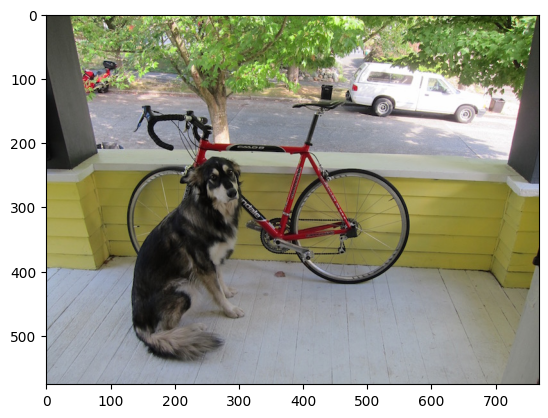

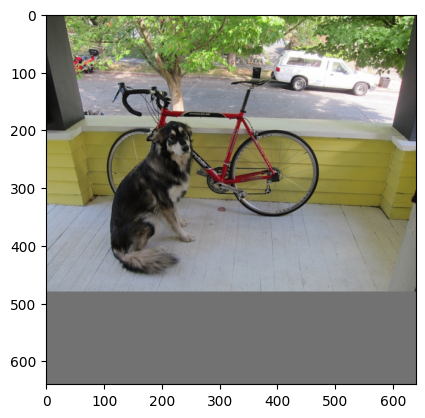

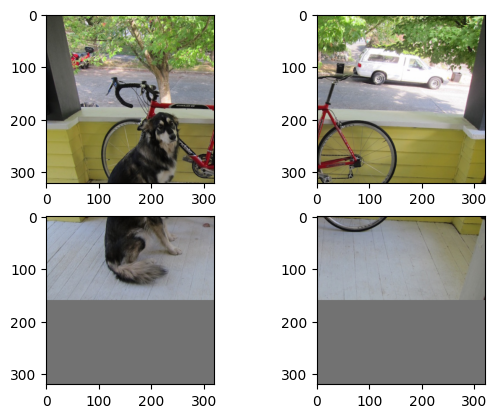

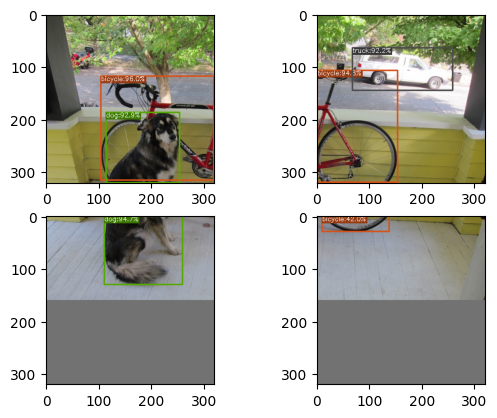

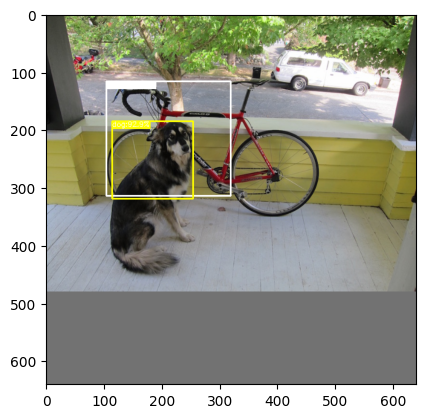

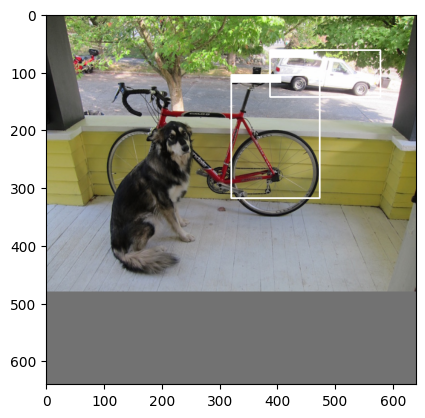

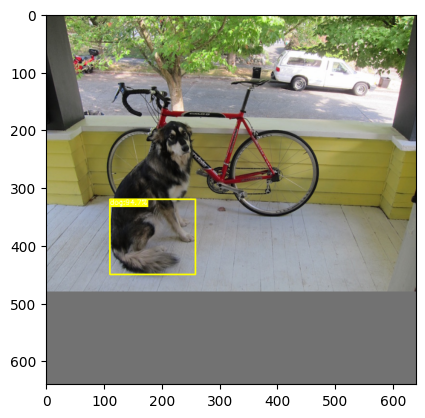

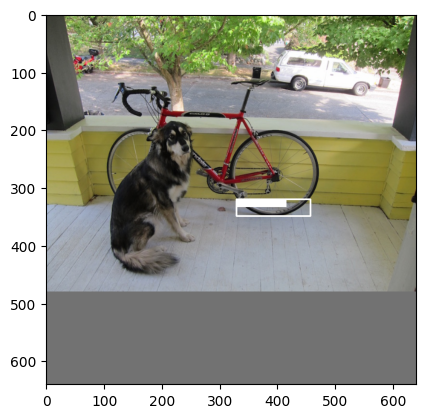

In [23]:
split_image_demo_pre(predictor, image_name, model)